# Project: Predicting Orders

You just joined a delivery company that follows a slot-based system for the couriers to fullfil the orders that come in. For simplification, you can imagine those slots are non-overlapping hours, so that every every city has 24 slots every day, one for each hour. Company needs to know the optimal number of couriers that are needed on every hour slot of every city. Too many couriers, and there will be many idle couriers not earning money. Too few couriers, and orders will have to wait to be processed, leading to higher delivery times.

At the moment, Operations decides manually how many couriers are needed, based on past demand. As the number of cities grows, this becomes unsustainable. They want to automate the process by which they decide how many courier-slots should be opened every hour. For simplification, we can assume that every Sunday at midnight, we need to know how many couriers we need for every hour of the week that is starting. That means that if today is Sunday, May 8th 23:59, they want us to know how many orders will be placed every hour of the week that goes from May 9th 00:00 to May 15th 23:00, both included. Every Sunday, you can use all data from that week to forecast the next one.

This problem has many steps, but we will keep this project to the order forecast for one city: we want to know, for one city and every Sunday, how many orders we're going to receive on every hour of the upcoming week.


# Import/Clean Data and Create Features

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%%capture


#visualization
!pip install dexplot
import dexplot as dxp
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Calendars
!pip install calplot
!pip install july
import july
from july.utils import date_range
import calplot

#Thymeboost for outlier inspection
!pip install ThymeBoost
from ThymeBoost import ThymeBoost as tb

#Regulars
import pandas as pd
import numpy as np
import datetime

#Models
!pip install xgboost
import xgboost
from xgboost import XGBRegressor

import itertools

#Evaluation metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor

#Smape equation sourced from online: https://www.statology.org/smape-python/
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
#Import data
df = pd.read_csv("/content/drive/MyDrive/Intelligent Data Design/bse-time-series-main.zip (Unzipped Files)/bse-time-series-main/data/data_BCN.csv")

#Turn time into datetime
df['time'] = pd.to_datetime(df['time'])


#Get date column without times and create aggregated df
df['date'] = pd.to_datetime(df['time']).dt.date

#Set time as index
df = df.set_index("time")
#Get hour column from time
df['hour'] = df.index.hour

#Get month column from time
df['month'] = df.index.month

#Get day of week column from time
df['day'] = df.index.weekday
#February 1 2021 (Obs 1) was a Monday, so replace day numbers with names
df["day"].replace({0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday",4: "Friday",5: "Saturday", 6:"Sunday"}, inplace=True)

#Get day of month column from time
df['day_of_month'] = df.index.day

#Create season column
bins = [0, 2, 5, 8, 11, 12]
labels = ['Winter', 'Spring', 'Summer','Autumn', 'Winter']
df['season'] = pd.cut(df['month'], bins, labels=labels, ordered=False)

#Drop city column as no unique values and provides no information
df = df.drop(columns=['city'])

df['week'] = df.index.week

# Data Inspection/Visualization

In [ ]:
#Get daily figures
daily = df.groupby(["date"]).sum()
daily = daily.drop(columns=["hour", "month", "day_of_month"])

In [ ]:
#Create buckets using cut method for visualization purpose
bins = [-1, 5, 8, 11, 14, 17, 20, 23]
labels = ['Not Open', 'Early Morning', 'Late Morning', 'Midday', 'Tarde', 'UK Dinner', 'Spanish Dinner']
df['ToD'] = pd.cut(df['hour'], bins, labels=labels)

#Remove first 5 hours of the day as they include no useful information for the algorithm
df = df[df.ToD != ("Not Open")]

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


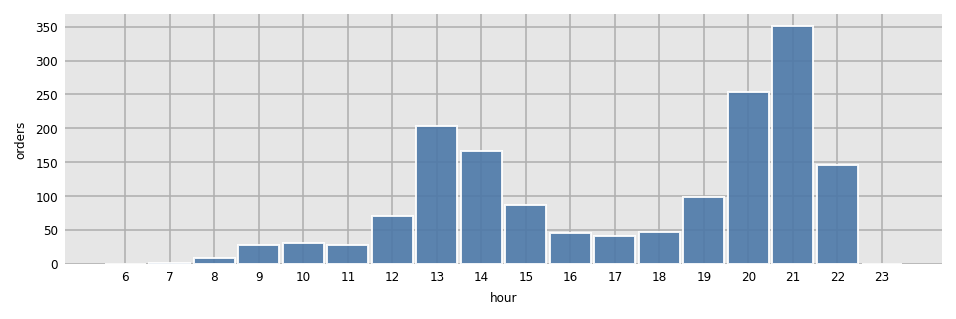

In [ ]:
#Visualize hourly figures
dxp.bar(x='hour', y='orders', data=df, orientation='v', aggfunc='median')

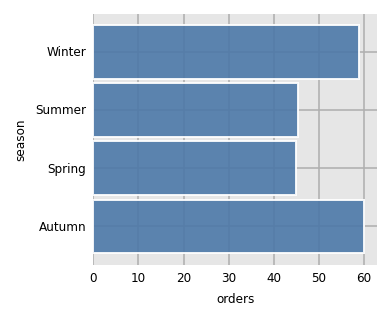

In [ ]:
#Visualize seasonality
dxp.bar(y='season', x='orders', data=df, orientation='h', aggfunc='median')

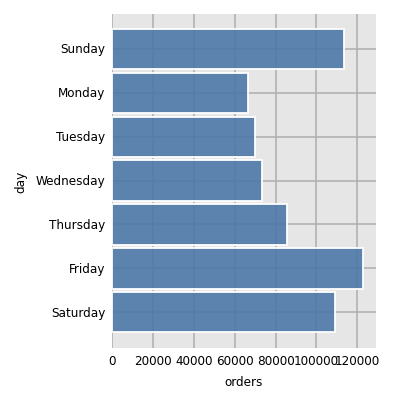

In [ ]:
#Visualize popular days of week
dxp.bar(y='day', x='orders', data=df, orientation='h', aggfunc='sum', y_order=['Saturday', 'Friday', 'Thursday','Wednesday','Tuesday','Monday','Sunday'])#, split='season', stacked=True)

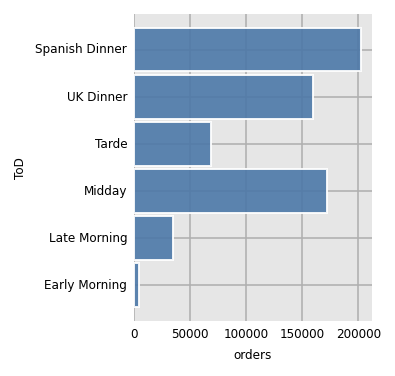

In [ ]:
#Visualize broader time of day
dxp.bar(x='orders', y='ToD', data=df, orientation='h', aggfunc='sum', y_order=['Early Morning', 'Late Morning', 'Midday', 'Tarde', 'UK Dinner', 'Spanish Dinner'])#, split='season', stacked=True)

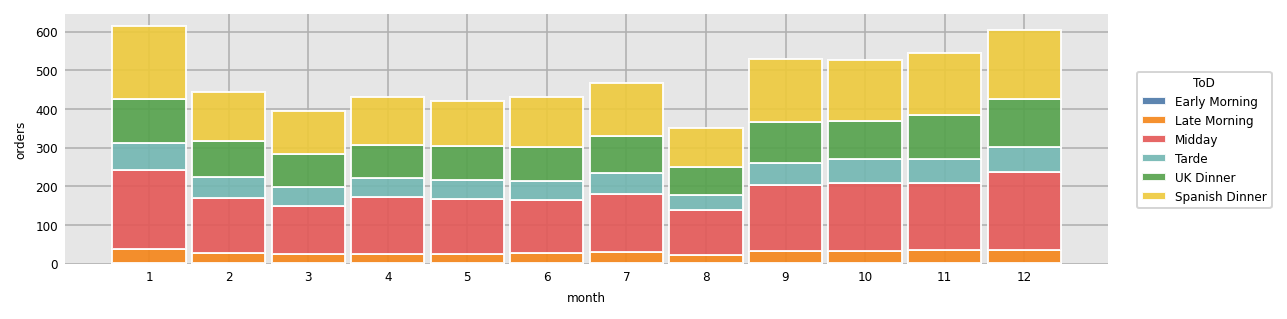

In [ ]:
#Visualize time of day and month to inspect for lunch being more popular at certain times of year for example
dxp.bar(x='month', y='orders', data=df, orientation='v', aggfunc='median', split='ToD', stacked=True)

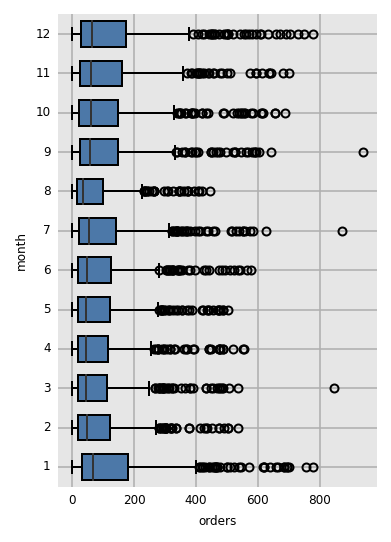

In [ ]:
#Visualize orders by month to look for outliers
dxp.box(y='month', x='orders', data=df)

Big outliers in September, July, and March. January and December were most popular months - likely because of cold weather

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


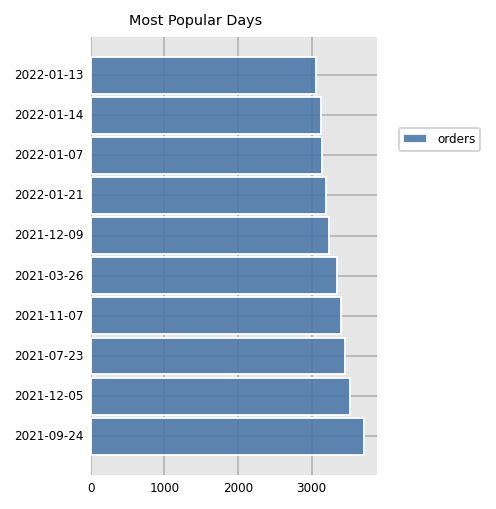

In [ ]:
pop_days = pd.DataFrame(df.groupby('date')['orders'].sum().sort_values(ascending=False))
dxp.bar(data=pop_days.head(10), orientation='h', title='Most Popular Days')

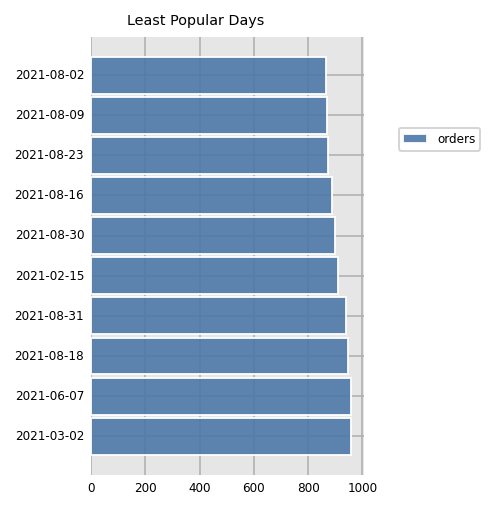

In [ ]:
pop_days = pd.DataFrame(df.groupby('date')['orders'].sum().sort_values(ascending=False))
dxp.bar(data=pop_days.tail(10), orientation='h', title='Least Popular Days')

In the summer, August in particular, product was not in high demand. This is likely because people are not working, on vacation, and spending time with family with more time to cook.

Analysis of Top 3:

*   September 24 was the La Merce festival
*   December 5 was slightly colder than usual, but no other major events except the following day was a public holiday
*   July 23 - Feast of Sant Joan

Overall - cursory searches generally did not reveal anything special about the most popular days. Despite a deep Google search and look at weather history, there is no obvious indication that anything unusual happened these days in Barcelona.



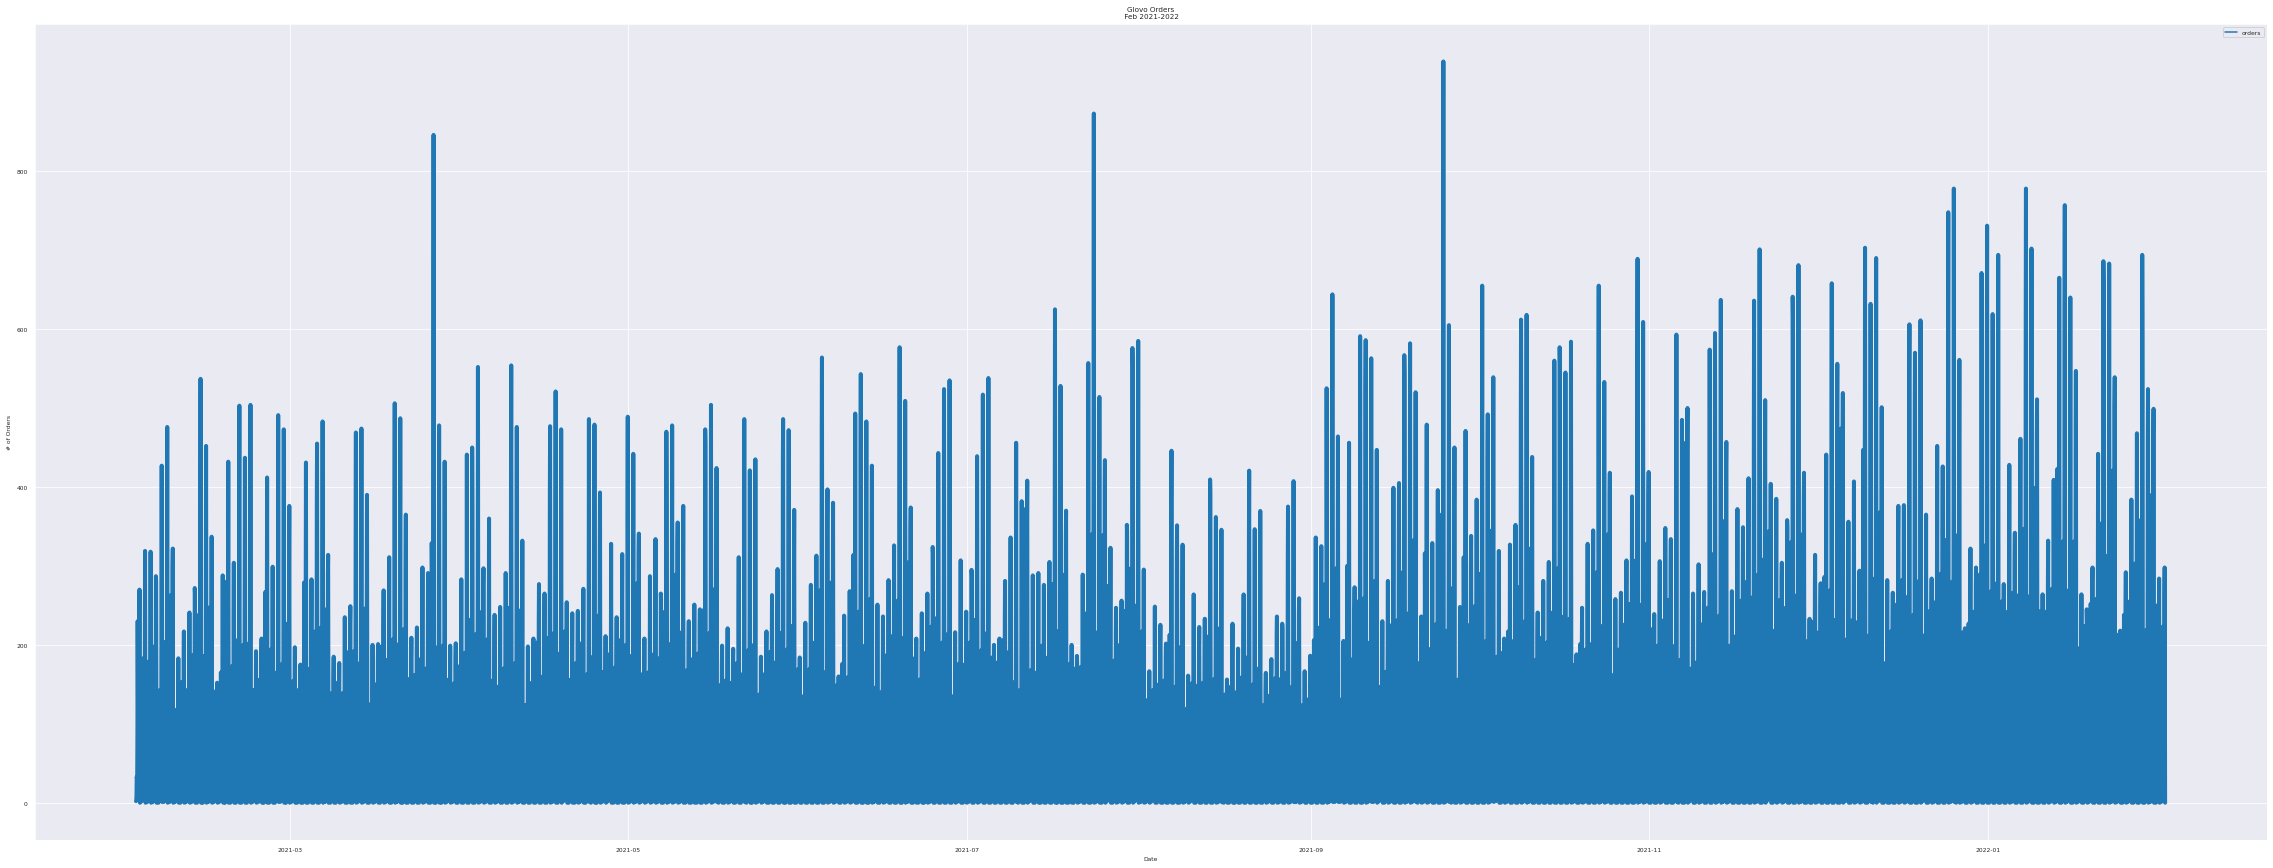

In [ ]:
#Below we can see a fairly stationary time series, though demand has increased slightly over time
sns.set_style('darkgrid')
dims = (40, 15)
fig, ax = plt.subplots(figsize=dims)

ax = sns.lineplot(data=df.filter(items=['orders']),
                  palette='tab10',
                  legend='full', lw=4)

plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('# of Orders')
plt.xlabel('Date')
plt.title('Orders\n Feb 2021-2022')
plt.show()

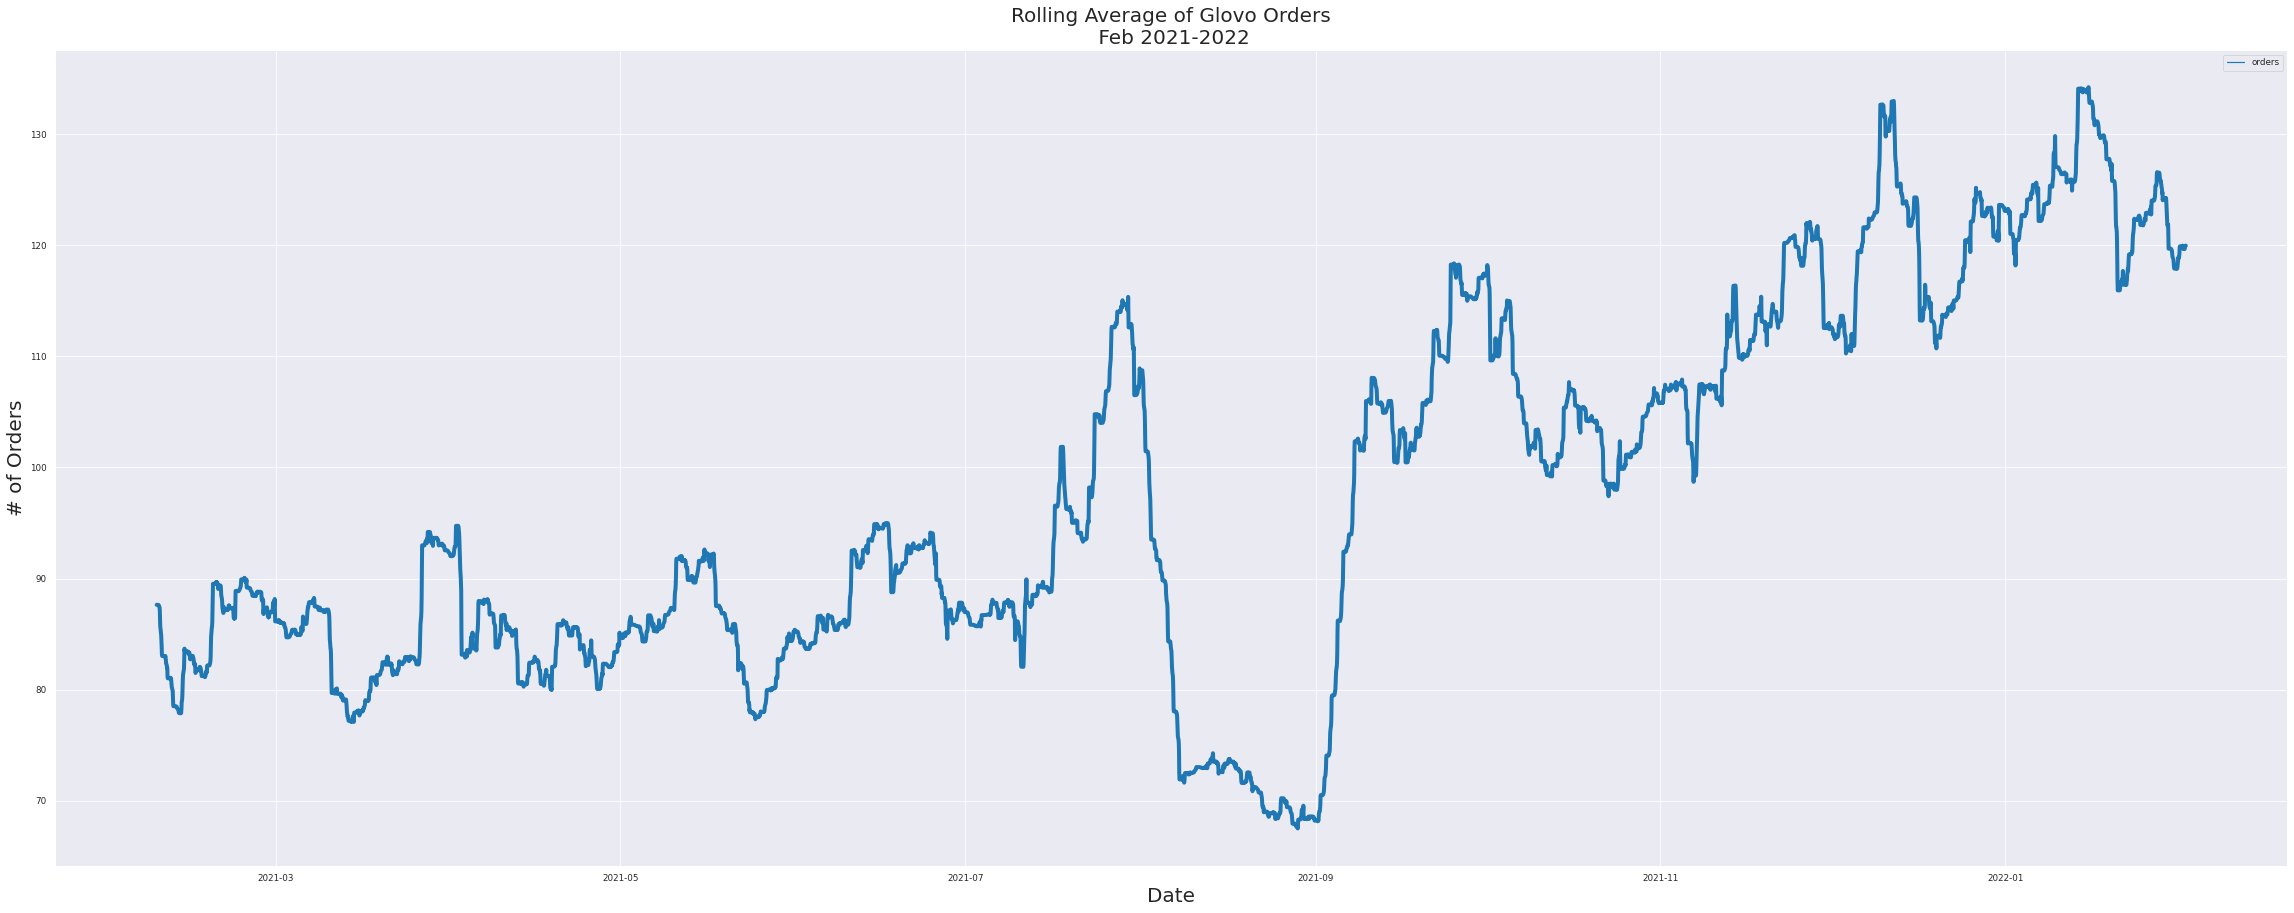

In [ ]:
#Below we can see a fairly stationary time series, though demand has decreased slightly over time
sns.set_style('darkgrid')
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20})
dims = (40, 15)
fig, ax = plt.subplots(figsize=dims)

ax = sns.lineplot(data=df.filter(items=['orders']).rolling(126).mean(),
                  palette='tab10',
                  legend='full', lw=4)
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('# of Orders')
plt.xlabel('Date')
plt.title('Rolling Average of Orders\n Feb 2021-2022')
plt.show()

We definitely have a major outlier in August and the beginning of September. Below we can see that weeks 31-34, which are all in September, have the least amount of orders

In [ ]:
df.filter(items=['orders','week']).groupby(["week"]).sum().sort_values(by='orders')

orders
week         
34     8613.5
33     8695.4
31     9135.0
32     9242.8
10     9820.0
20     9822.0
11    10265.0
6     10307.0
15    10339.0
16    10456.0
13    10547.0
21    10632.0
14    10737.0
17    10817.0
8     10854.0
22    10910.0
26    10932.0
25    10976.0
18    11007.0
9     11022.0
27    11063.0
7     11199.0
19    11611.0
24    11628.0
35    11644.6
23    11785.0
12    11800.0
28    12127.0
42    12583.0
40    12668.0
30    12782.3
36    13218.0
41    13279.0
37    13331.0
43    13332.0
29    13465.0
44    13541.0
45    13841.0
50    14091.0
46    14256.0
5     14270.0
39    14290.0
38    14555.0
4     14854.0
48    15050.0
52    15179.0
47    15189.0
3     15407.0
51    15704.0
49    15791.0
1     16005.0
2     16522.0

## Thymeboost for Outlier Detection

Used Thymeboost outlier detection here

Below we can see a lot of outliers in the data. Further, we can see 

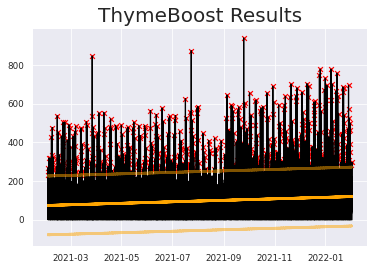

In [ ]:
boosted_model = tb.ThymeBoost()
output = boosted_model.detect_outliers(df['orders'],
                                       trend_estimator='linear',
                                       seasonal_estimator='fourier',
                                       seasonal_period=4,
                                       global_cost='maicc',
                                       fit_type='global')
boosted_model.plot_results(output)
#boosted_model.plot_components(output)


## Calendar Heatmaps

Below I do some calendar heatmap visualizations to inspect for unusual days

Source: https://medium.com/analytics-vidhya/calendar-heatmaps-a-perfect-way-to-display-your-time-series-quantitative-data-ad36bf81a3ed

In [ ]:
import datetime as dt
df['Day'] = pd.to_datetime(df.index).date

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


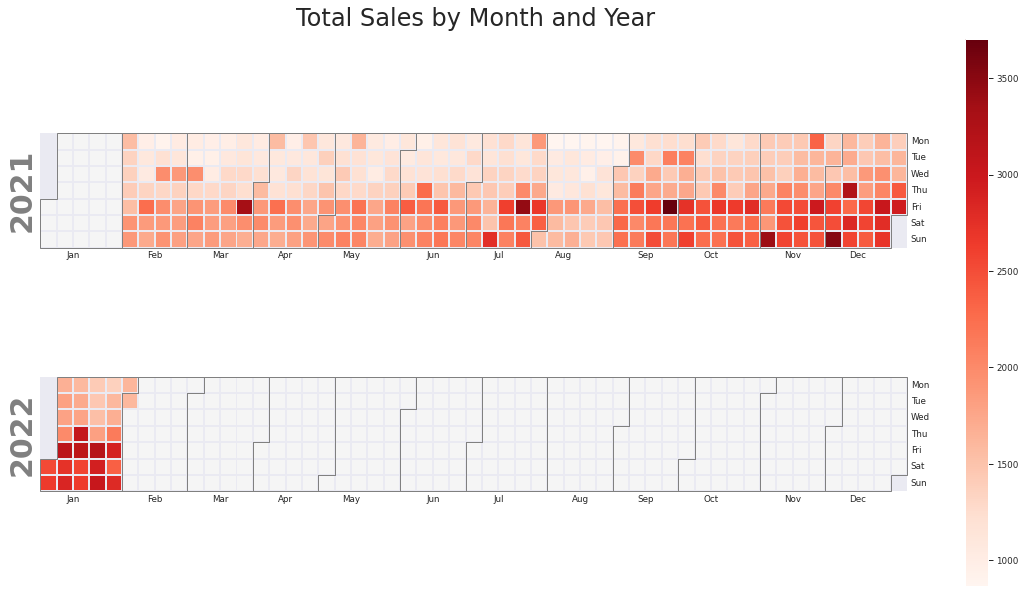

In [ ]:
pl1 = calplot.calplot(data = df['orders'],how = 'sum', cmap = 'Reds', figsize = (16, 8), suptitle = "Total Sales by Month and Year",textfiller='-')

In [ ]:
cal = df.groupby(["month", "day_of_month", "hour"]).sum()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1ab7cfe290>,
      dtype=object)

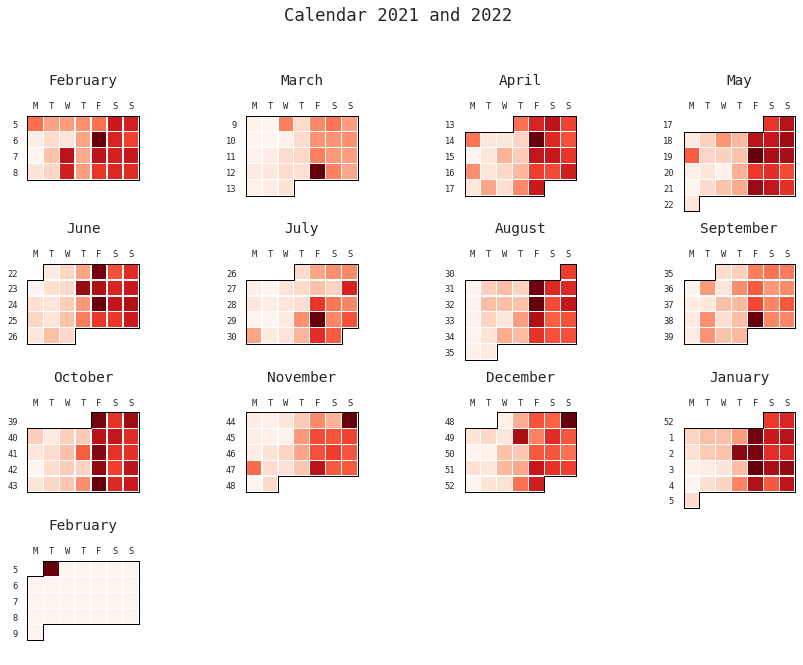

In [ ]:
dates = date_range("2021-02-01", "2022-02-01")
dsum = df.groupby('date').sum()
july.calendar_plot(dates, dsum['orders'], cmap = 'Reds')

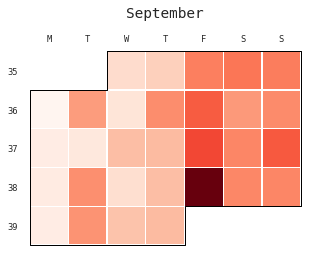

In [ ]:
#Below we can see September 23
july.month_plot(dates, dsum['orders'], cmap = 'Reds', year=2021, month=9)

Again, based on a search there was nothing unusual about the weather on the busier dates

# Models

Below we chose to run a naive model along with an XGBoost and a Random Forest, for a total of three models

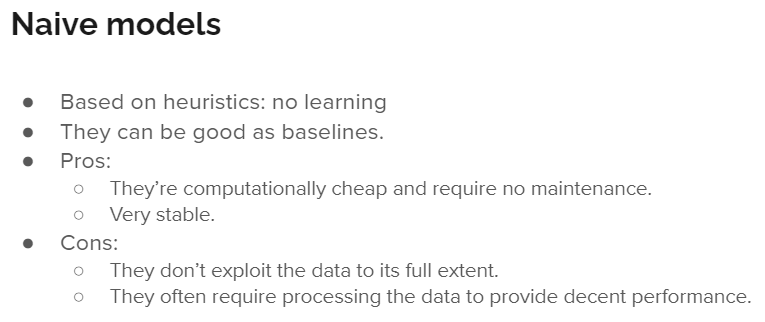



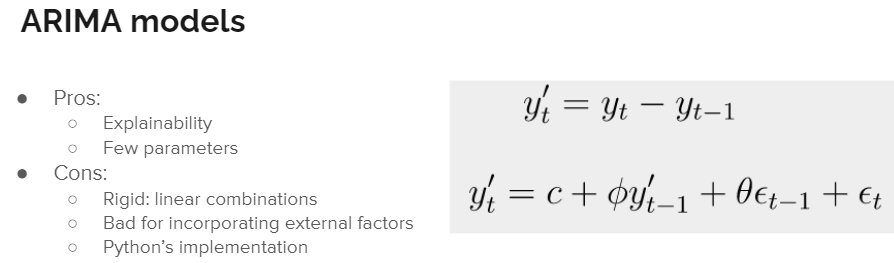



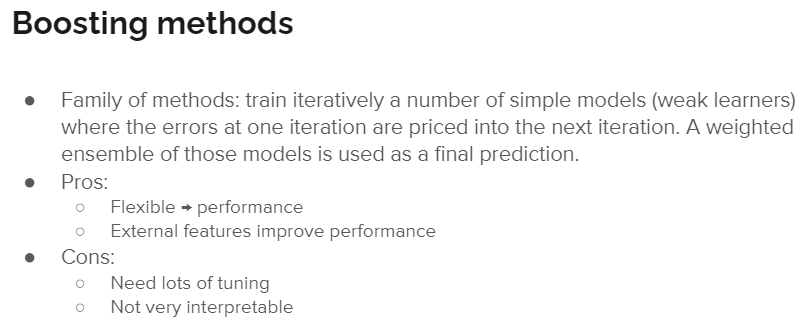

### Preprocessing

In [ ]:
#Reset weekday so its numeric and not a string
df['day'] = df.index.weekday

#Filter df to workable features
data = df.filter(items=['hour', 'day', 'month', 'orders'], axis=1)

In [ ]:
#Create list of dataframes each one with a new week of the year incorporated
weeks = []
#126 observations for each week (53 weeks with one duplicate)
counter = 126
for i in range(0,53):
  weeks.append(data.iloc[0:counter])
  counter += 126

### Naive Model
Predict next week based on previous week

In [ ]:
#Dropping final 36 observations so I can have an even number of weeks
data = data.head(6552)

In [ ]:
counter = 0
next_counter = 126
indiv_weeks =[]
for i in range(0,53):
  indiv_weeks.append(data.iloc[counter:next_counter])
  counter += 126
  next_counter += 126

In [ ]:
#Start at second week
counter1 = 1

#Create empty lists to populate metrics and predictions
mses = []
smapes = []
predictions = []
actuals = []

#For loop running a naive prediction once a week
for i in range(1,52):

  # Get actual and predicted data
  actual = list(indiv_weeks[counter1]['orders'])
  pred = indiv_weeks[counter1 - 1]['orders']

  #Move counter to next week
  counter1 += 1

  #Append predictions (prior week), actual observations, and evaluation metrics to lists
  predictions.append(pred)
  actuals.append(actual)
  smapes.append(smape(actual, pred))
  mses.append(mse(actual, pred))

  

#Create df of evaluation metrics for comparison later
smp = pd.DataFrame({'Naive SMAPE': smapes})
ms = pd.DataFrame({'Naive MSE': mses})

#Create single list of predictions and actual obvservations
preds = list(itertools.chain.from_iterable(predictions))
actuals = list(itertools.chain.from_iterable(actuals))

#Turn into dataframe. Drop first week as it had no prior week to predict on
preds_df = pd.DataFrame(list(zip(actuals,preds)), columns=['Actual Orders','Naive Prediction'], index=data[126:].index)

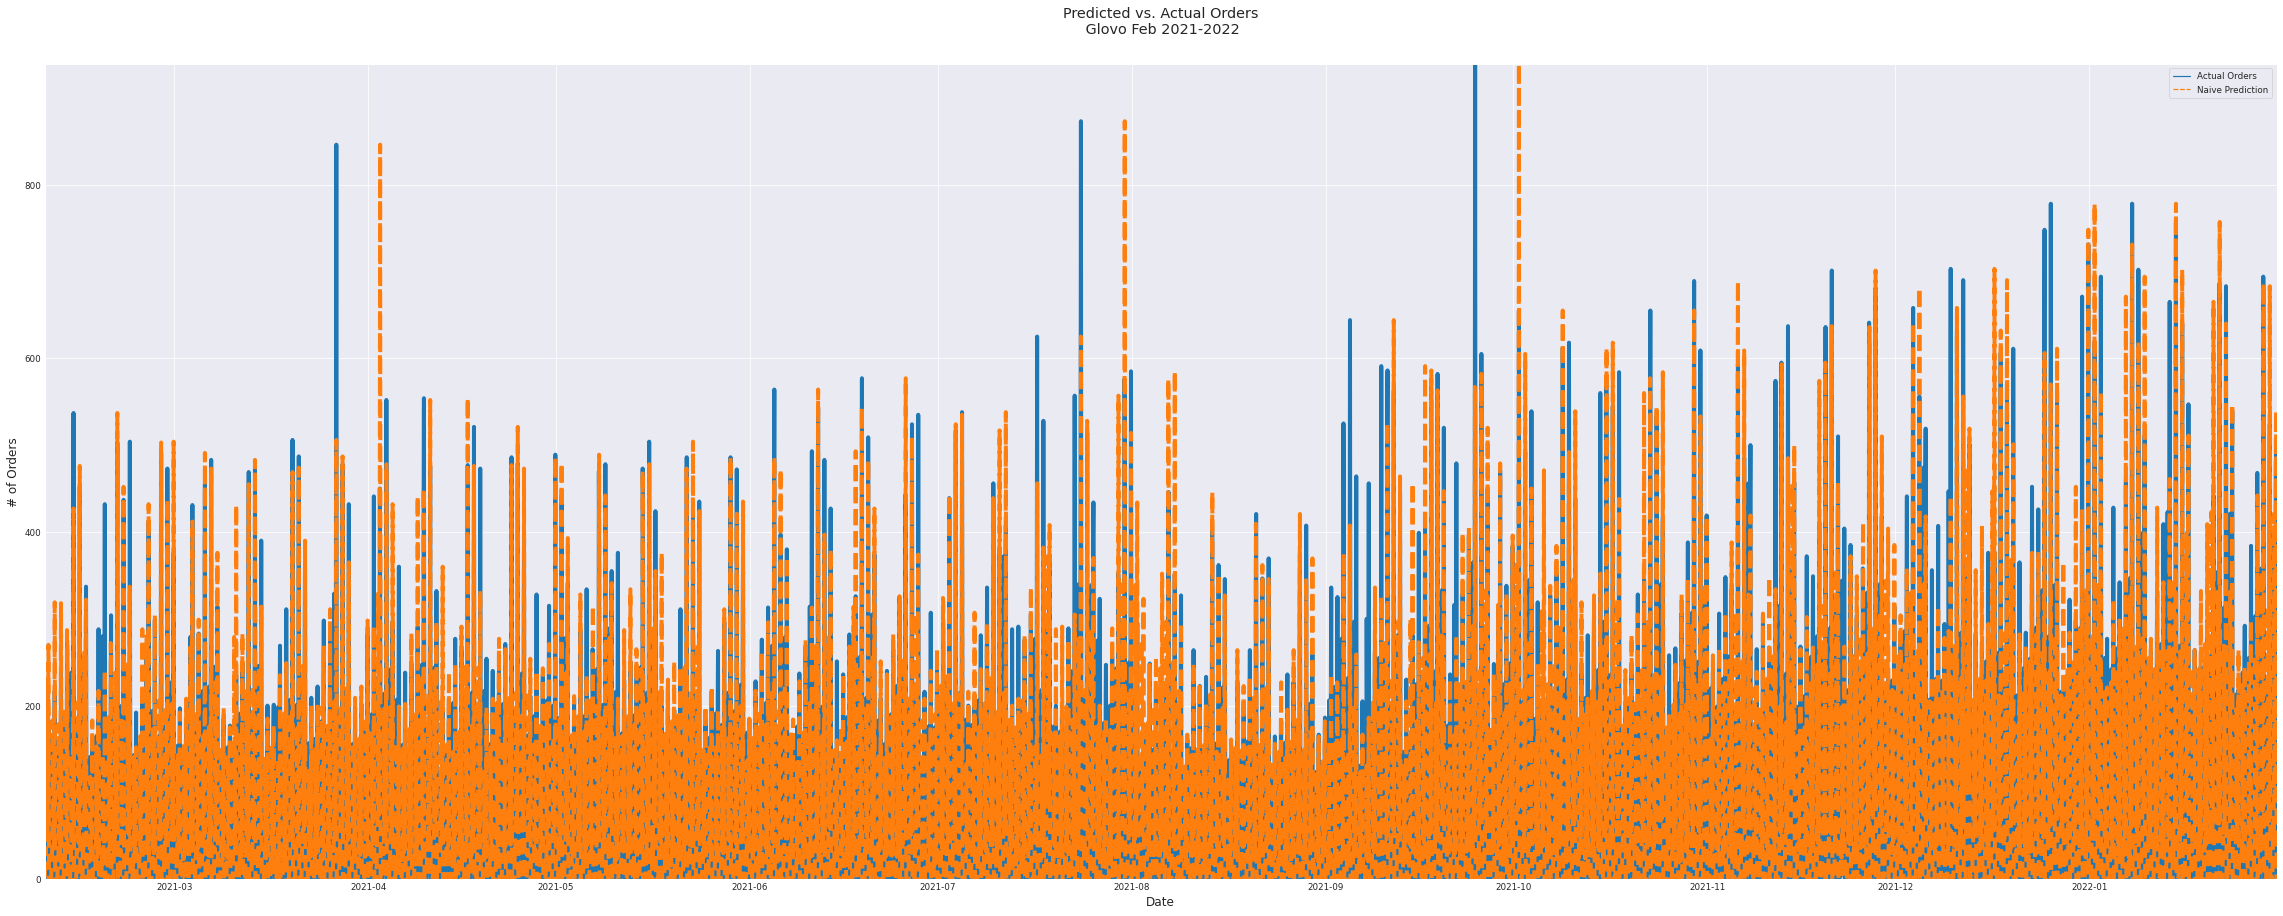

In [ ]:
sns.set_style('darkgrid')
dims = (40, 15)
fig, ax = plt.subplots(figsize=dims)

ax = sns.lineplot(data=preds_df,
                  palette='tab10',
                  legend='full', lw=4)

plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('# of Orders')
plt.xlabel('Date')
plt.title('Predicted vs. Actual Orders\n Feb 2021-2022')
plt.show()

The above naive model where I'm just predicting this week based on last week looks decent. Below I pick a random week to inspect more closely

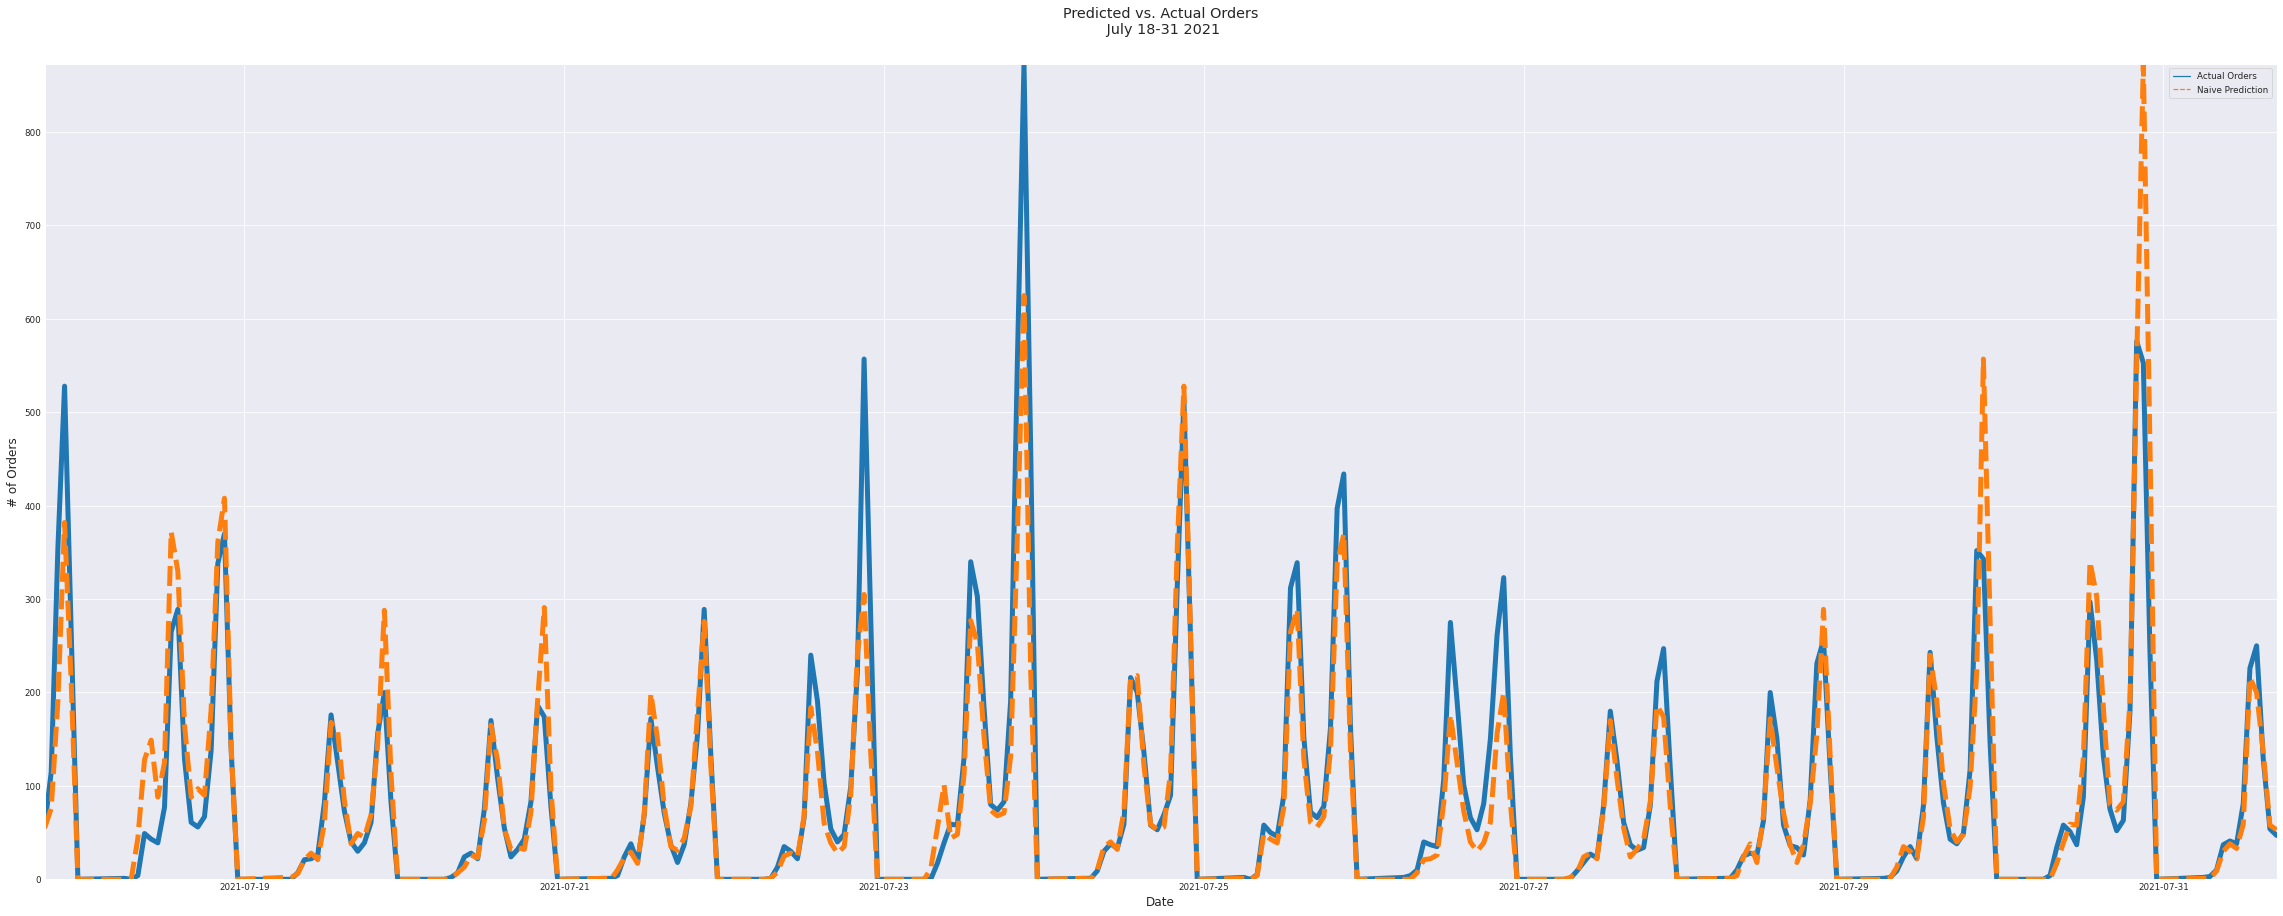

In [ ]:
#Select two week period in July to inspect
sns.set_style('darkgrid')
dims = (40, 15)
fig, ax = plt.subplots(figsize=dims)

ax = sns.lineplot(data=preds_df[2874:3126],
                  palette='tab10',
                  legend='full', lw=5)

plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('# of Orders')
plt.xlabel('Date')
plt.title('Predicted vs. Actual Orders\n July 18-31 2021')
plt.show()

This looks quite good however company would have been shortstaffed a few times

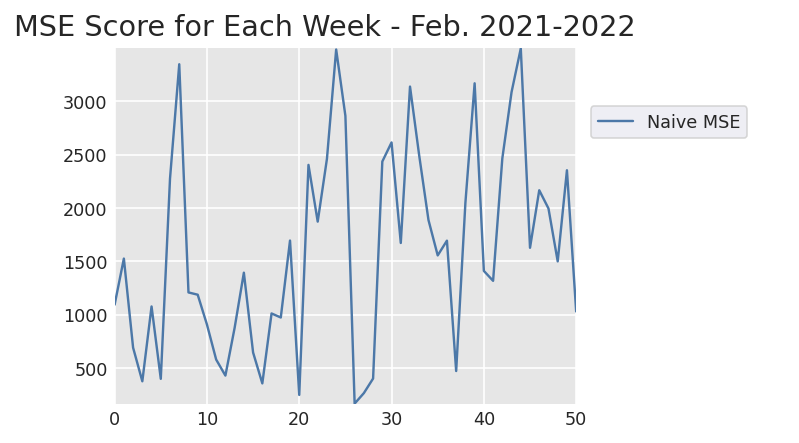

In [ ]:
dxp.line(data=ms, title="MSE Score for Each Week - Feb. 2021-2022")

MSE and SMAPE scores are all over the place

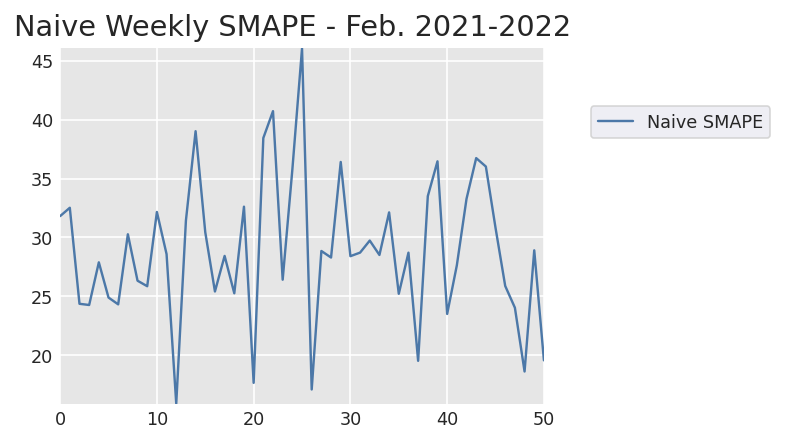

In [ ]:
dxp.line(data=smp, title="Naive Weekly SMAPE - Feb. 2021-2022")

### XGBoost

Note no hyperparameter tuning here or with Random Forest. Ideally these should be optimized in real-world environment.

With time-series the model must be trained on the past and predict the future so I can't use k-fold cross validation

In [ ]:
%%capture
data = df.filter(items=['hour', 'day', 'month', 'orders'], axis=1)
counter2 = 0

mses = []
smapes = []
predictions = []

for i in range(0,52):

  #Get train data
  train = weeks[counter2]
  y = train['orders']
  x = train.drop(columns=['orders'], axis=1)

  #Get Test Data
  test = weeks[counter2+1].tail(126)
  ytest = test['orders']
  xtest = test.drop(columns=['orders'], axis=1)
  
  #Move counter to next week
  counter2 += 1

  try: 
    #Experimenting with different parameters here, occassionally got NA errors so just used a try/except if some weeks wouldn't predict correctly
    xgb = XGBRegressor()
    model = xgb.fit(x, y)
    pred = model.predict(xtest)

  except: #Running basic model when I get a NA error
    #Run model
    xgb = XGBRegressor()
    model = xgb.fit(x, y)
    pred = model.predict(xtest)

  #Evaluate model
  predictions.append(pred)
  smapes.append(smape(ytest, pred))
  mses.append(mse(ytest, pred))

preds = list(itertools.chain.from_iterable(predictions))

#Drop last day for simplicity
#data = data.head(6552)
preds_df['XGB Predicted'] = preds[126:]

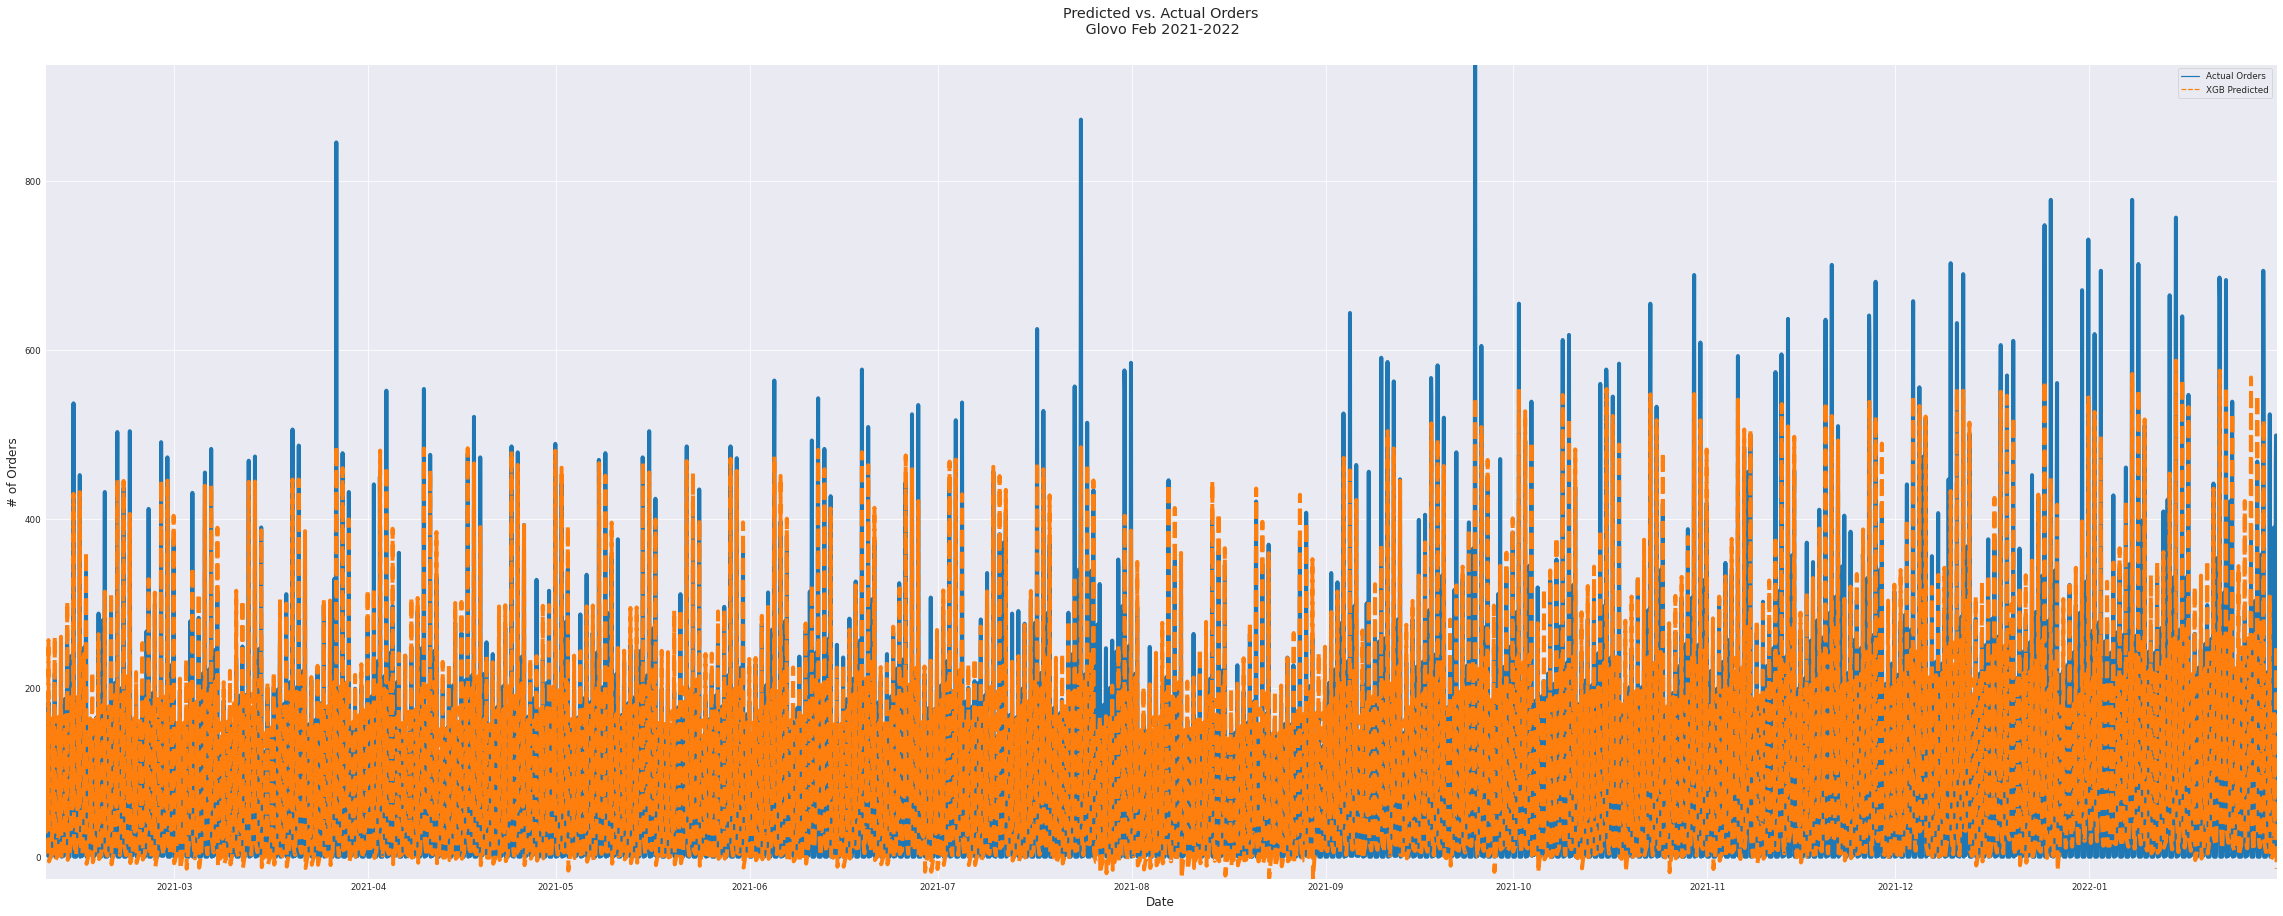

In [ ]:
sns.set_style('darkgrid')
dims = (40, 15)
fig, ax = plt.subplots(figsize=dims)

ax = sns.lineplot(data=preds_df.filter(items=['Actual Orders', 'XGB Predicted']),
                  palette='tab10',
                  legend='full', lw=4)

#ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('# of Orders')
plt.xlabel('Date')
plt.title('Predicted vs. Actual Orders\n Feb 2021-2022')
plt.show()

Notice negative predictions. If predictions can be capped at 0 or the absolute value can be taken the results will improve

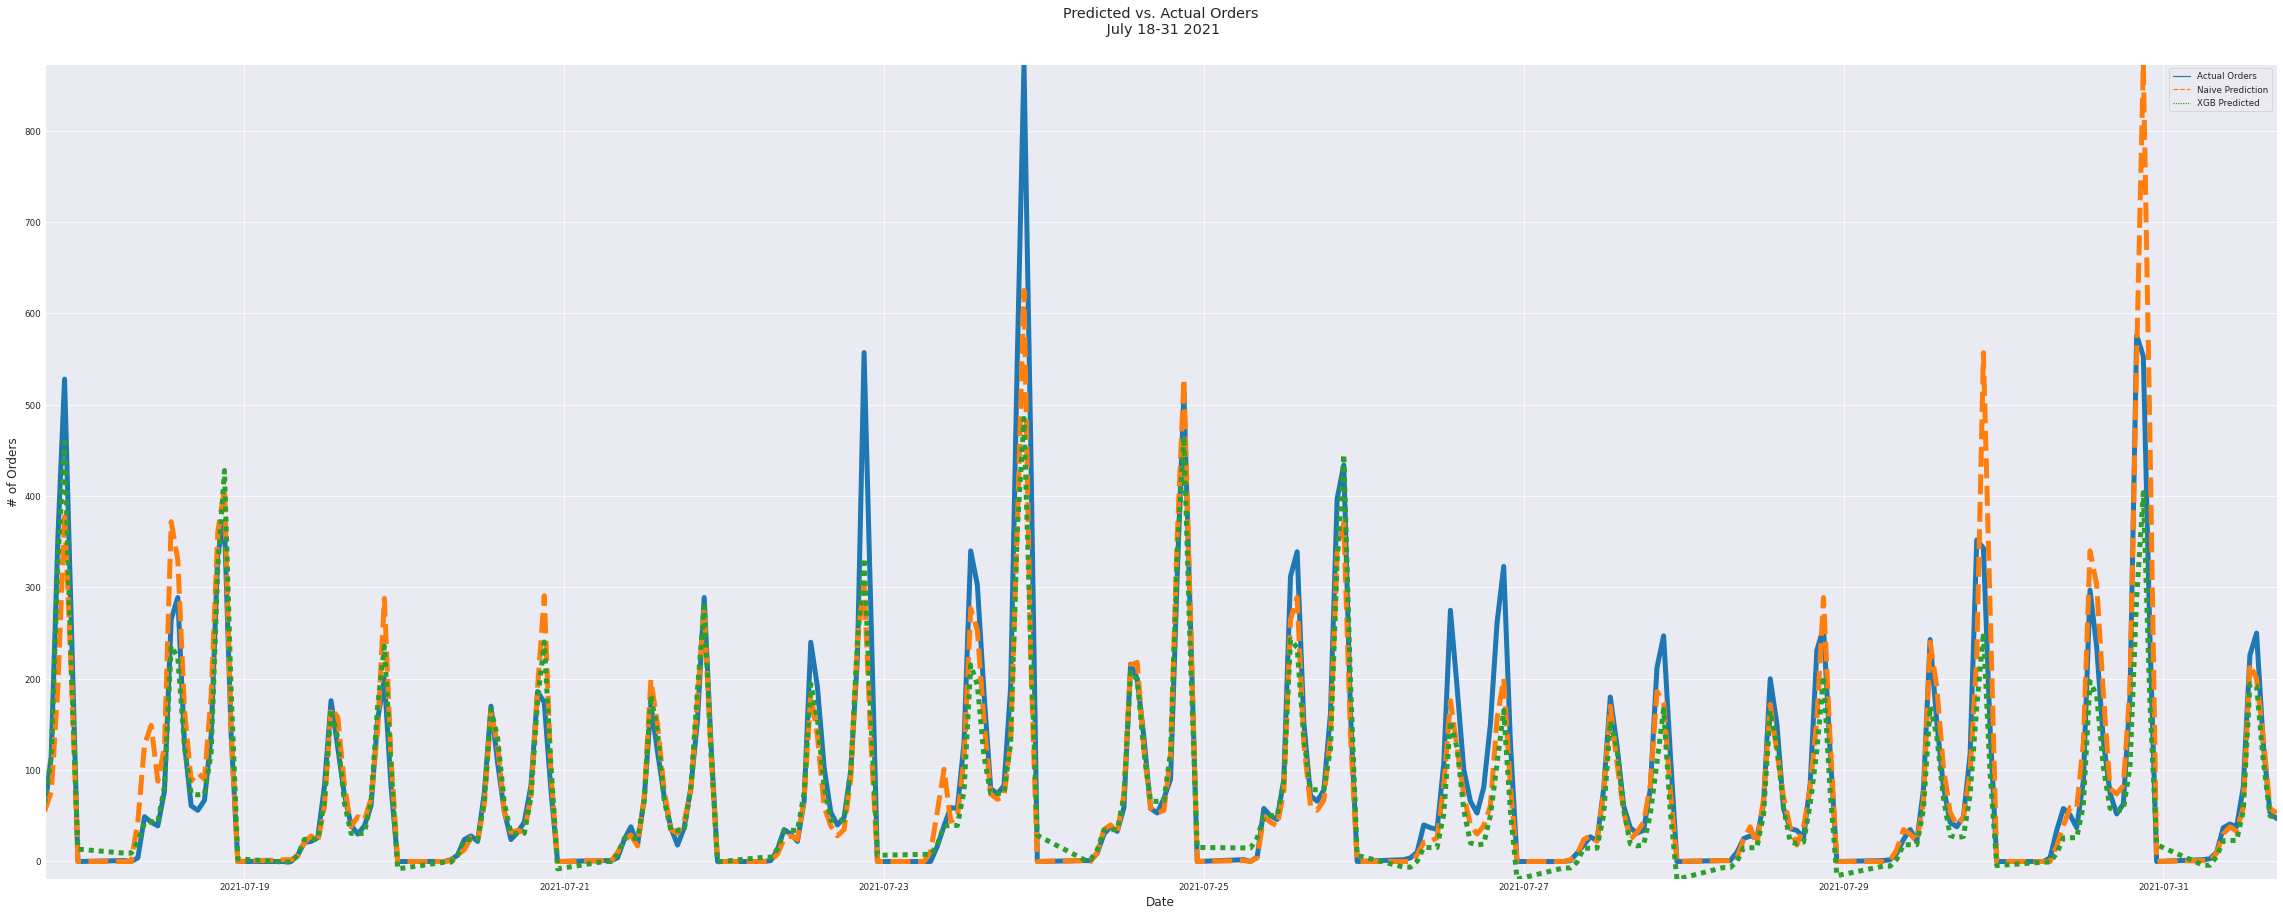

In [ ]:
sns.set_style('darkgrid')
dims = (40, 15)
fig, ax = plt.subplots(figsize=dims)

ax = sns.lineplot(data=preds_df[2874:3126],
                  palette='tab10',
                  legend='full', lw=5)

plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('# of Orders')
plt.xlabel('Date')
plt.title('Predicted vs. Actual Orders\n July 18-31 2021')
plt.show()

Basic XGB doesn't perform much better than the naive model

In [ ]:
smp['XGBoost SMAPE'] = smapes[1:]
ms['XGBoost MSE'] = mses[1:]

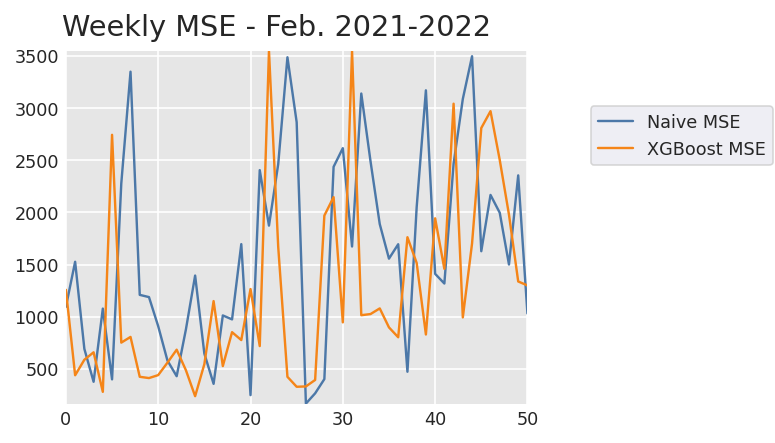

In [ ]:
dxp.line(data=ms, title="Weekly MSE - Feb. 2021-2022")

The MSEs are similar here

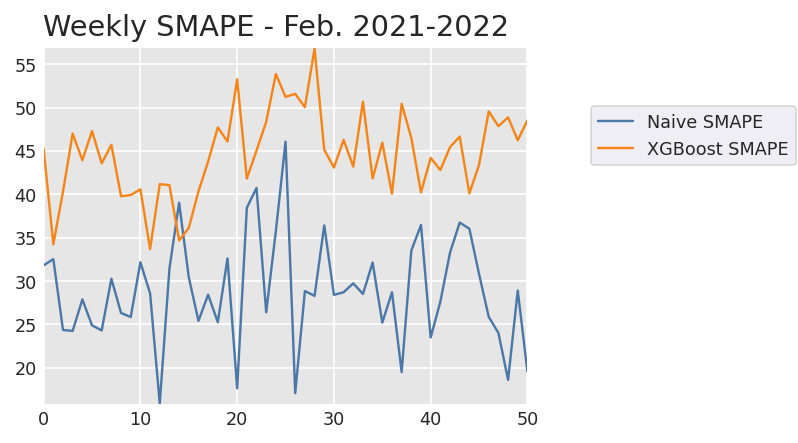

In [ ]:
dxp.line(data=smp, title="Weekly SMAPE - Feb. 2021-2022")

The naive performed much better than the default XGBoost according to SMAPE!

### Random Forest

In [ ]:
%%capture
counter3 = 0

mses = []
smapes = []
predictions = []

for i in range(0,52):

  #Get train data
  train = weeks[counter3]
  y = train['orders']
  x = train.drop(columns=['orders'], axis=1)

  #Get Test Data - tail of next weeks dataset is our test set
  test = weeks[counter3+1].tail(126)
  ytest = test['orders']
  xtest = test.drop(columns=['orders'], axis=1)
  
  #Move counter to next week
  counter3 += 1

  try: 
    #Experimenting with different parameters here, occassionally got NA errors so just used a try/except if some weeks wouldn't predict correctly
    rf = RandomForestRegressor()
    model = rf.fit(x, y)
    pred = model.predict(xtest)

  except: #Run basic rf model when if I get a NA error
    #Run model
    rf = RandomForestRegressor()
    model = xgb.fit(x, y)
    pred = model.predict(xtest)

  #Evaluate model
  predictions.append(pred)
  smapes.append(smape(ytest, pred))
  mses.append(mse(ytest, pred))

preds = list(itertools.chain.from_iterable(predictions))

#Drop last day for simplicity
#data = data.head(6552)
preds_df['Random Forest Predicted'] = preds[126:]

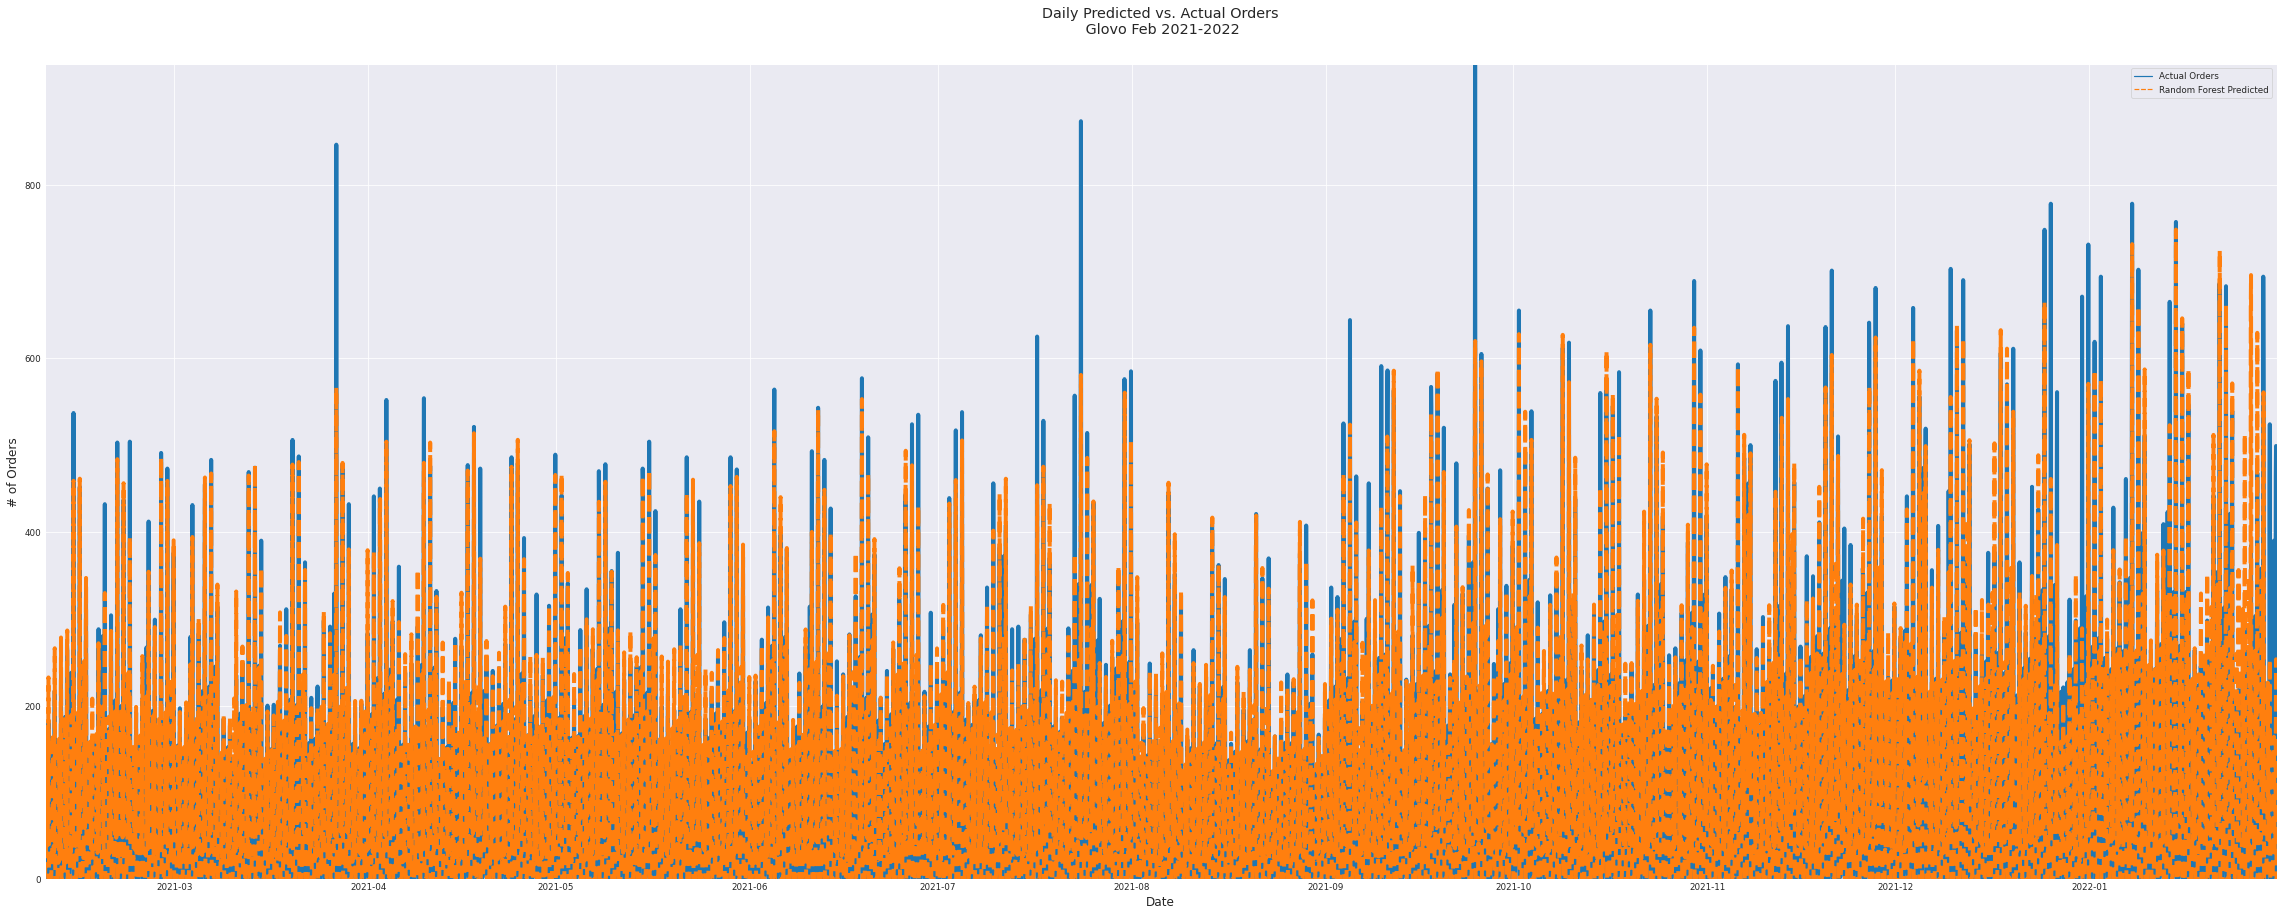

In [ ]:
sns.set_style('darkgrid')
dims = (40, 15)
fig, ax = plt.subplots(figsize=dims)

ax = sns.lineplot(data=preds_df.filter(items=['Actual Orders', 'Random Forest Predicted']),
                  palette='tab10',
                  legend='full', lw=4)

plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('# of Orders')
plt.xlabel('Date')
plt.title('Daily Predicted vs. Actual Orders\n Feb 2021-2022')
plt.show()



It's quite surprising that even with more input data the model performs worse than with less data to train on in the beginning. Perhaps this indicates that using only the weeks prior to predict is better than using all of the data at once

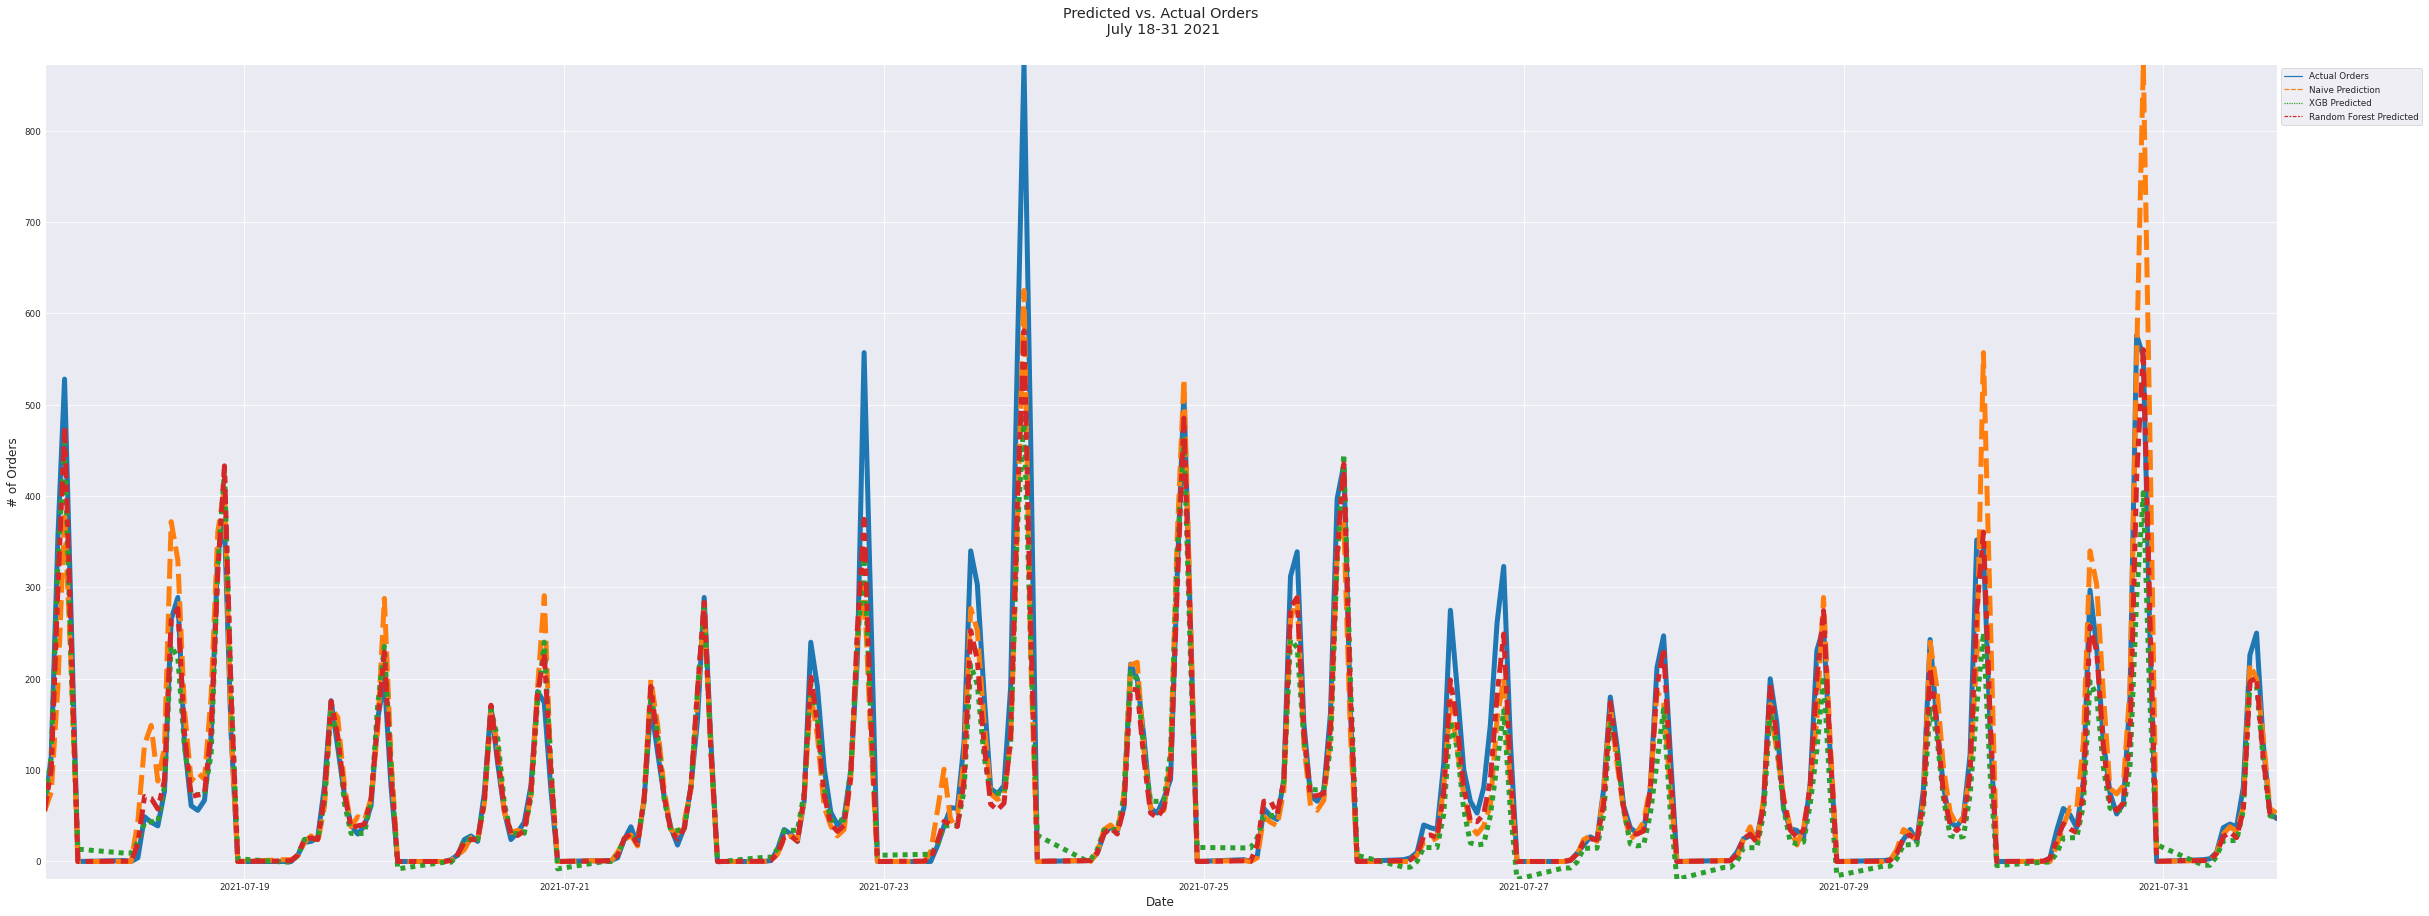

In [ ]:
sns.set_style('darkgrid')
dims = (40, 15)
fig, ax = plt.subplots(figsize=dims)

ax = sns.lineplot(data=preds_df[2874:3126],
                  palette='tab10',
                  legend='full', lw=5)

plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('# of Orders')
plt.xlabel('Date')
plt.title('Predicted vs. Actual Orders\n July 18-31 2021')
plt.show()

The Random Forest seems to perform best on this week

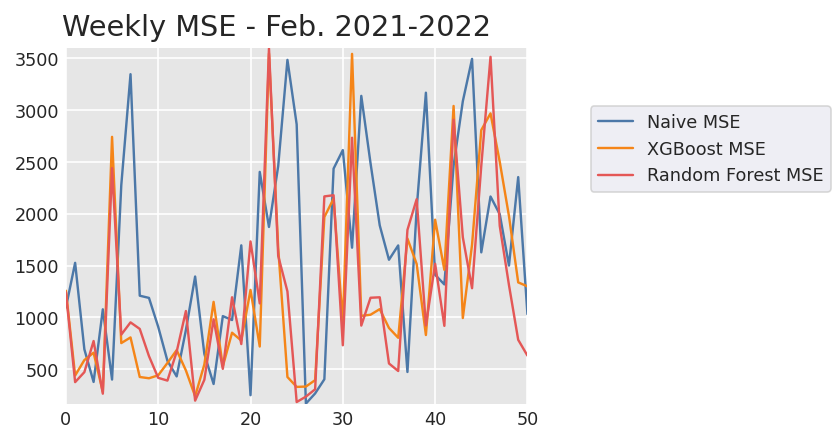

In [ ]:
smp['Random Forest SMAPE'] = smapes[1:] #Dropping very first observation so can overlap
ms['Random Forest MSE'] = mses[1:]
dxp.line(data=ms, title="Weekly MSE - Feb. 2021-2022")

The MSE scores are quite similar all the way through

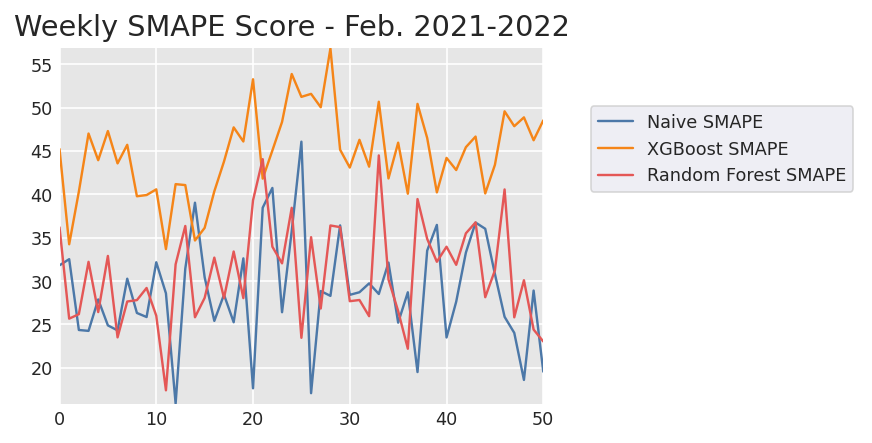

In [ ]:
dxp.line(data=smp, title="Weekly SMAPE Score - Feb. 2021-2022")

The Random Forest and Naive perform better than the XGBoost with SMAPE evaluation

## Final Analysis

The below findings indicate a few key takeaways:



1.   The naive model (just predicting this week based on last week) worked very well and held up to the RF and XGBoost algorithms, and actually performed best according to the SMAPE evaluation metric.
2.   Multiple evaluation metrics are important - the MSE moving averages indicate that XGBoost performed best, while the SMAPE moving averages indicate that XGboost performed worst. 

Finally - I recognize a gridsearch and hyperparameters tuning would be best practice here, however I believe it is outside the scope of this assignment. Further tuning and experimentation would definitely improve things.



No handles with labels found to put in legend.


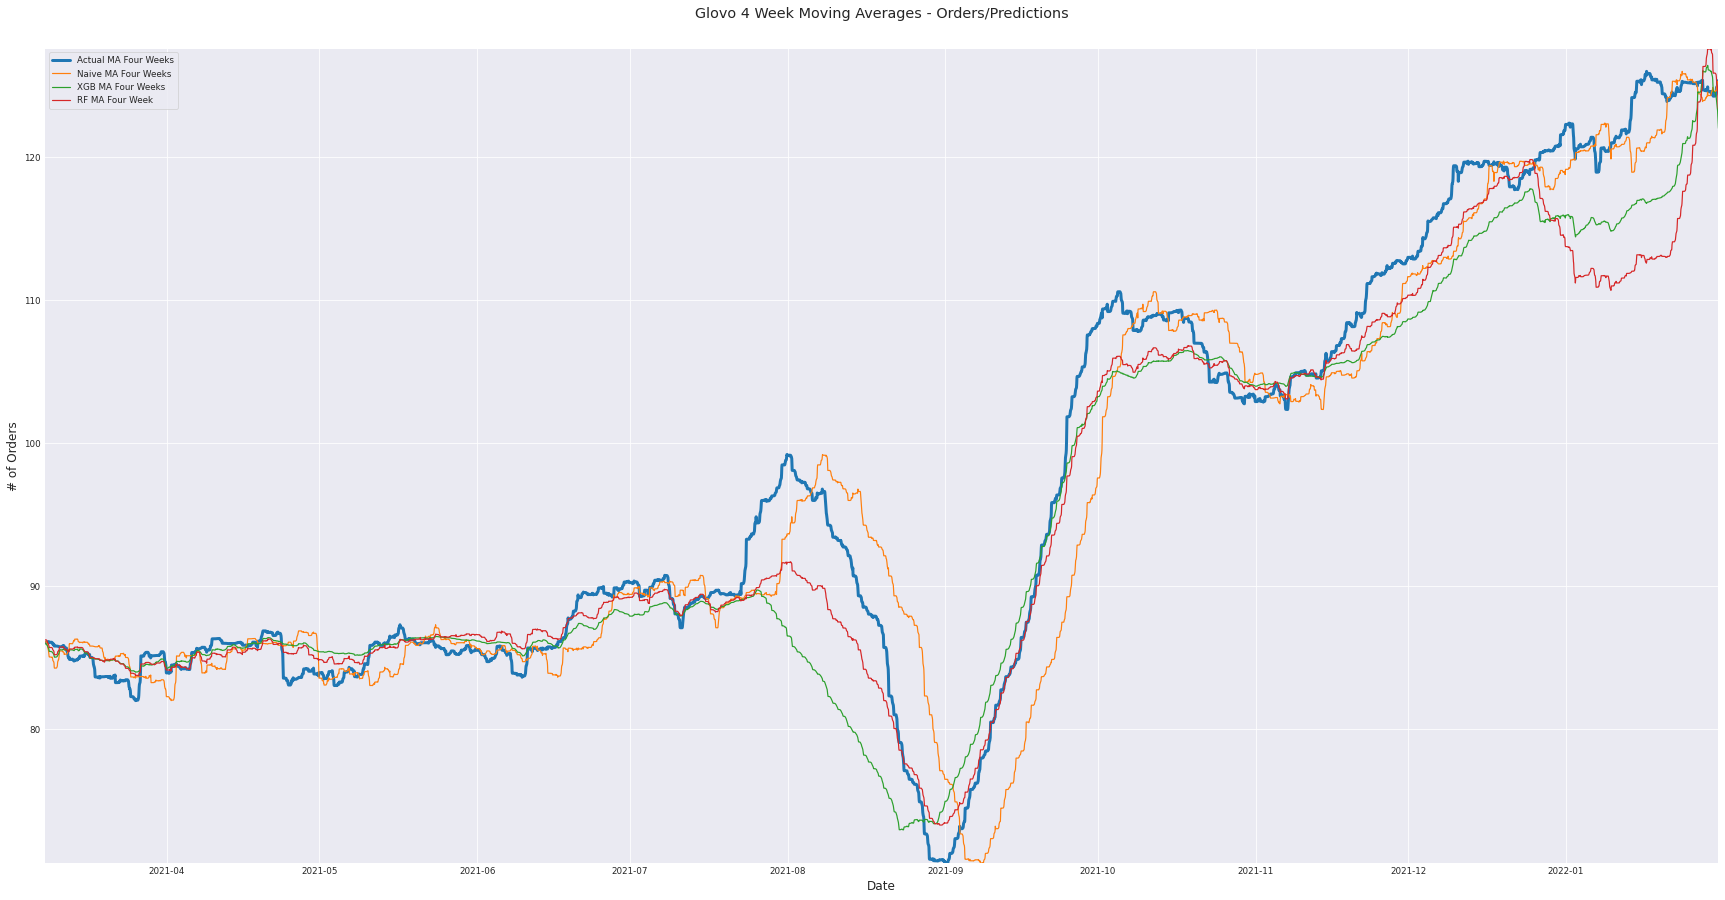

In [ ]:
sns.set_style('darkgrid')
dims = (30, 15)
fig, ax = plt.subplots(figsize=dims)

# ax = sns.lineplot(data=preds_df.filter(items=['Actual Orders', 'Naive Prediction', 'XGB Predicted', 'Random Forest Predicted']).rolling(126).mean,
#                   palette='tab10',
#                   legend='full', lw=3)

plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('# of Orders')
plt.xlabel('Date')
plt.plot(preds_df['Actual Orders'].rolling(504).mean(), label='Actual MA Four Weeks', linewidth=3)
plt.plot(preds_df['Naive Prediction'].rolling(504).mean(),label= 'Naive MA Four Weeks')
plt.plot(preds_df['XGB Predicted'].rolling(504).mean(),label= 'XGB MA Four Weeks')
plt.plot(preds_df['Random Forest Predicted'].rolling(504).mean(),label= 'RF MA Four Week')
plt.legend(loc='best')
plt.title('4 Week Moving Averages - Orders/Predictions')
plt.show()

In [ ]:
len(ms)

51

No handles with labels found to put in legend.


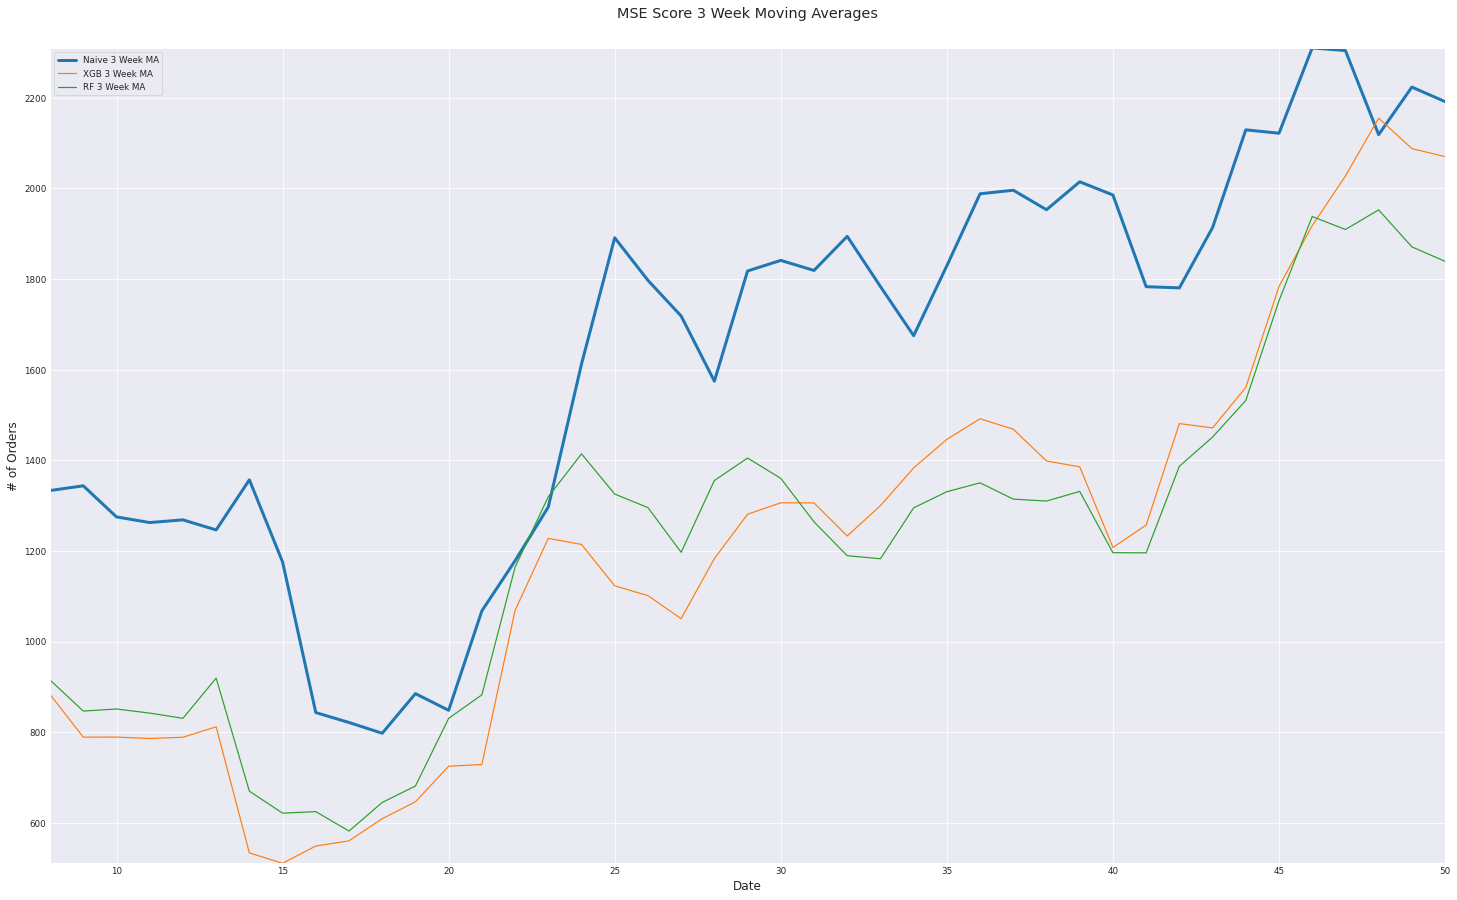

In [ ]:
sns.set_style('darkgrid')
dims = (25, 15)
fig, ax = plt.subplots(figsize=dims)
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('# of Orders')
plt.xlabel('Date')
plt.plot(ms['Naive MSE'].rolling(9).mean(), label='Naive 3 Week MA', linewidth=3)
plt.plot(ms['XGBoost MSE'].rolling(9).mean(),label= 'XGB 3 Week MA')
plt.plot(ms['Random Forest MSE'].rolling(9).mean(),label= 'RF 3 Week MA')
plt.legend(loc='best')
plt.title('MSE Score 3 Week Moving Averages')
plt.show()

In [ ]:
smp.columns

Index(['Naive SMAPE', 'XGBoost SMAPE', 'Random Forest SMAPE'], dtype='object')

No handles with labels found to put in legend.


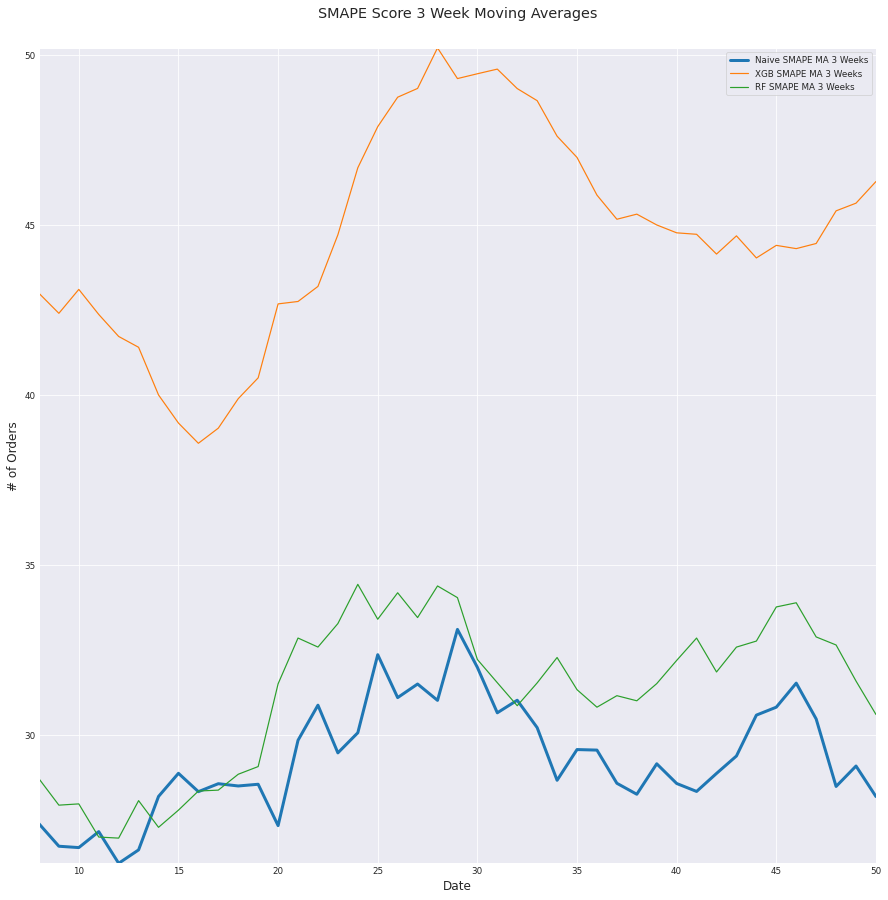

In [ ]:
sns.set_style('darkgrid')
dims = (15, 15)
fig, ax = plt.subplots(figsize=dims)

# ax = sns.lineplot(data=preds_df.filter(items=['Actual Orders', 'Naive Prediction', 'XGB Predicted', 'Random Forest Predicted']).rolling(126).mean,
#                   palette='tab10',
#                   legend='full', lw=3)

plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('# of Orders')
plt.xlabel('Date')
plt.plot(smp['Naive SMAPE'].rolling(9).mean(), label='Naive SMAPE MA 3 Weeks', linewidth=3)
plt.plot(smp['XGBoost SMAPE'].rolling(9).mean(),label= 'XGB SMAPE MA 3 Weeks')
plt.plot(smp['Random Forest SMAPE'].rolling(9).mean(),label= 'RF SMAPE MA 3 Weeks')
plt.legend(loc='best')
plt.title('SMAPE Score 3 Week Moving Averages')
plt.show()